# COMPUTATIONAL SCIENCE PROJECT

# Enhancing Classical Nanoparticle Simulations with Electronic Corrections and Artificial Neural Networks.

This program utilises a number of machine learning methods implemented by the Scikit-Learn package.
https://scikit-learn.org/stable/

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from standard_vis import *

import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)

import os
import time
import matplotlib.pyplot as plt
import sys
import ast
import multiprocessing as mp
from copy import copy
from numpy import arange
from numpy import random

from scipy.spatial.distance import cdist,pdist
from scipy.stats import levene, pearsonr
from scipy import stats
from scipy.stats import uniform

from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn import utils
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterSampler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_regression

import graphviz 
import pydotplus
import collections


#REGRESSORS
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load the Data

In [2]:
X_df = pd.read_csv('../data/extracted_features.csv')

# Select training features by dropping excess target labels and other unused features
X_features = X_df.drop(['ID','Mermin_E', 'Delta_E', 'Delta_E/N', 'Fermi_L', 'CN_max', 'Classical_E/N', 'Classical_E', 'CLASS'], axis=1)

# Select target label
target_label = 'Delta_E'
y_label = X_df[target_label]

# Remove correlated features as found using the data science notebook
X_feats = X_features.drop([
    # N_total and R_avg kept as it improves results
    'R_min', # for correlation with N_shell/N_total
    'SCN_min', # for correlation with CN_min
    'SCN_avg', 'ABL_avg', 'BL_avg', # for correlation with CN_avg
    'SBL_min', 'SBL_max', 'SBL_avg', 'SBL_std', 'SBL_skew', 'SBL_kurt', # for correlation with BL
    'ABA_kurt', # For correlation with ABA_skew
    'BA_kurt', # For correlation with BA_std and BA_skew
    'SBA_min', # For correlation with BA_min
    'BA_skew', # for correlation with SBA_kurt
    'SBA_skew', 'SBA_kurt' # For correlation with BA_skew, BA_kurt etc
], axis=1)

X_feats.describe()

,N_total,N_shell/N_total,R_max,R_avg,R_std,R_skew,R_kurt,CN_min,CN_avg,CN_std,...,ABA_avg,ABA_std,ABA_skew,BA_min,BA_max,BA_avg,BA_std,SBA_max,SBA_avg,SBA_std
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,630.658451,0.493737,16.178408,12.379082,1.425252,0.249665,-0.076445,4.140845,9.289648,2.027581,...,94.453633,4.546140,-1.489444,46.201426,179.718642,95.883292,34.310193,179.421020,92.500173,33.690448
std,230.863656,0.062088,3.192038,1.719876,0.768881,0.470275,1.290653,1.384373,0.812617,0.204524,...,0.642780,0.703678,0.324080,2.348440,0.270844,0.456833,0.685949,0.476239,0.595776,0.571362
min,236.000000,0.388330,9.665202,8.592114,0.485009,-0.771003,-1.424023,1.000000,7.191851,1.549891,...,91.809172,2.960429,-2.614211,38.696325,178.432356,93.780515,33.084558,177.200898,90.973333,32.488791
25%,438.750000,0.445095,14.066641,11.147761,0.860560,-0.047503,-0.698671,3.000000,8.596462,1.874227,...,94.062653,4.052686,-1.685696,45.079956,179.657873,95.549346,33.517871,179.259944,92.120192,33.250572
50%,598.000000,0.487849,16.144654,12.359336,1.157117,0.216507,-0.308612,4.000000,9.498588,2.011459,...,94.548696,4.539342,-1.483863,46.980238,179.809065,95.977161,34.610787,179.552941,92.515976,33.664868
75%,819.750000,0.535529,18.127391,13.753966,1.849234,0.501196,0.126800,5.000000,10.014101,2.195830,...,94.955922,5.002913,-1.288867,47.906385,179.896390,96.254189,34.903179,179.728773,92.886249,34.140185
max,1214.000000,0.736842,25.874050,16.031342,3.929259,2.532002,13.654322,6.000000,10.591549,2.442414,...,95.696520,6.332264,-0.323653,49.333752,179.994264,96.637302,35.238230,179.988261,94.560597,35.035268


## Scale the feature set

In [3]:
X_scaled = RobustScaler().fit_transform(X_feats)

## Splitting the testing set and training set

In [4]:
y_label = np.array(y_label).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_label, test_size=0.20, random_state=42)

## Decision Tree Regressor

We will now train a decision tree regressor to identify the important features. We will first find the optimal hyper-parameters using a randomized search.

In [5]:
param_dist = dict(min_samples_split=stats.randint(2, 20),
                  min_samples_leaf=stats.randint(2, 20),
                  max_depth=stats.randint(1, 15),
                  criterion=['mae', 'friedman_mse','mse'],
                  max_features= [None, 'auto','sqrt','log2'],
                  splitter=['best','random']
                 )

model = DecisionTreeRegressor(max_leaf_nodes=None, random_state=42)

start = time.time()
reg = RandomizedSearchCV(model, param_dist, cv=10, n_iter=5000, random_state=42)
reg.fit(X_train, y_train)
stop = time.time()

print(f"Training time: {stop - start}s")

reg.best_params_

Training time: 278.19149017333984s


{'criterion': 'friedman_mse',
 'max_depth': 14,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'splitter': 'random'}

These are the best combination of hyper-parameters that could be found, and will now be used to train the decision tree regressor

In [6]:
model_DTR = DecisionTreeRegressor(random_state=42, max_leaf_nodes=None, 
                                  criterion='friedman_mse', splitter='random',
                                  max_depth=14, max_features=None,
                                  min_samples_leaf=3,min_samples_split=12)
start = time.time()
model_DTR.fit(X_train, y_train)

CV_scores = []
kf = KFold(n_splits=10, shuffle=False, random_state=42)

for cv_train_index, cv_test_index in kf.split(X_train, y_train):
    X_train_cv = X_train[cv_train_index, :]
    X_test_cv = X_train[cv_test_index, :]
    y_train_cv = y_train[cv_train_index]
    y_test_cv = y_train[cv_test_index]
    
    # fit model to training dataset
    model_DTR.fit(X_train_cv, y_train_cv)
    CV_scores.append(model_DTR.score(X_test_cv, y_test_cv))
    
stop = time.time()

accuracy = np.mean(CV_scores)
uncertainty = np.std(CV_scores)*2
training_score = model_DTR.score(X_train, y_train)
testing_score = model_DTR.score(X_test, y_test)

print('Training score:', np.round(training_score, 6))
print('CV Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")

Training score: 0.946125
CV Accuracy: 0.928986 +/- 0.053283
Testing score: 0.870621
Training time: 0.017952442169189453s


### Decision tree visualization

In [7]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(model_DTR, out_file=None, 
                                feature_names=X_feats.columns, #revise as needed
                                filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(dot_data) 
graph.render("images/combined-decision-tree", format='png') 

'images\\combined-decision-tree.png'

### Decision tree prediction accuracy

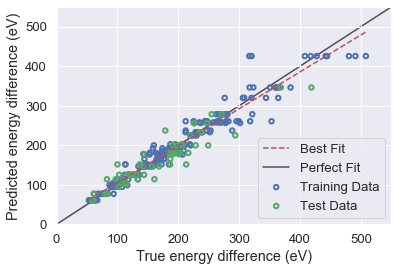

In [8]:
domain = [0,550]

plot_test_train(y_train, y_test, model_DTR.predict(X_test), model_DTR.predict(X_train), range_set=False, range_x=domain, range_y=domain, 
             tag='_Train', mod='MLP', axis_label='energy difference (eV)')
plt.savefig("images/combined_45degree_plot_decision_tree.jpg", dpi=600, bbox_inches='tight')
plt.show()

### Decision tree learning curve

Training time: 4.988685131072998s


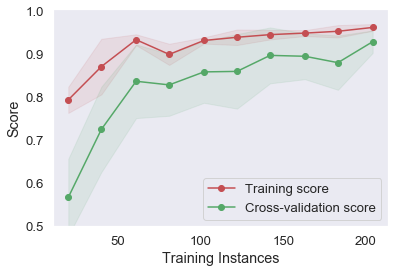

In [9]:
title = ""
estimator = model_DTR

start= time.time()
plot_learning_curve(estimator, title, X_train, y_train, \
                    ylim=(0.5, 1.005), cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
stop = time.time()
print(f"Training time: {stop - start}s")
plt.savefig("images/combined-decision_tree_learning_curve.jpg", dpi=600, bbox_inches='tight')
plt.show()

### Feature importance profile

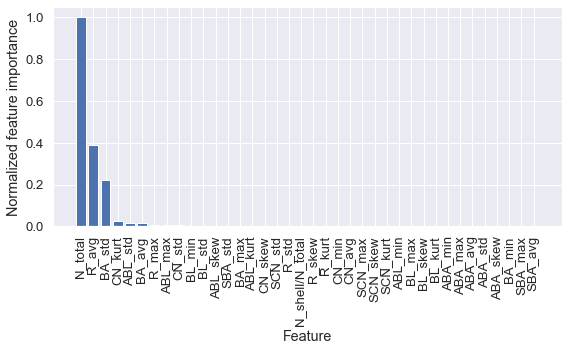

The important features are: ['N_total', 'R_avg', 'BA_std', 'CN_kurt', 'ABL_std', 'BA_avg', 'R_max', 'ABL_max', 'CN_std', 'BL_min', 'BL_std', 'ABL_skew']


In [10]:
X_feats.columns =(list(X_feats.columns.values) )
plot_feature_importance(
    X_feats.columns, 
    model_DTR.feature_importances_,
    show_cols = 42
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig("images/combined-feature_importance_profile", dpi=600, bbox_inches='tight')
plt.show()
important_features = get_important_features(X_feats.columns, model_DTR.feature_importances_, cutoff = 0.002)
print("The important features are:",important_features)

## ANN Regressor

Now we will train an artificial neural network (ANN).  We will use a Multilayer Perceptron.  

We will use the important features identified using the decision tree above and redo the test train split using the raw features rather than the scaled features.

In [11]:
important_headers = important_features
Reduced_X_feats = X_feats [important_headers]
X_train, X_test, y_train, y_test = train_test_split(Reduced_X_feats, y_label, test_size=0.25, random_state=42)
X_train = np.array(X_train)

Once again we will optimise the hyper-parameters, selecting from a large number of layer (0 to 3) and neuron (3 to 10) configurations.

In [12]:
param_dist = dict(activation=["identity"], #, "tanh", "relu", "logistic"],
                  alpha=np.logspace(-2, 2, num=10, base=10),
                  learning_rate=["adaptive","invscaling","constant"],
                  solver=["lbfgs"], # "sgd",
                  max_iter=stats.randint(50, 1000),
                  hidden_layer_sizes=[(),(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(3,2),(4,2,),(5,2,),(6,2,),(7,2,),
                                      (8,2,),(9,2,),(10,2,),(4,3,),(5,3,),(6,3,),(7,3,),(8,3,),(9,3,),(10,3,),
                                      (5,4,),(6,4,),(7,4,),(8,4,),(9,4,),(10,4,),(6,5,),(7,5,),(8,5,),(9,5,),(10,5,),
                                      (7,6,),(8,6,),(9,6,),(10,6,),(8,7,),(9,7,),(10,7,),(9,8,),(10,8,),(10,9,),
                                      (4,3,2),(5,3,2),(6,3,2),(7,3,2),(8,3,2),(9,3,2),(10,3,2),(5,4,2),(6,4,2),(7,4,2),
                                      (8,4,2),(9,4,2),(10,4,2),(6,5,2),(7,5,2),(8,5,2),(9,5,2),(10,5,2),(5,4,3),(6,4,3),
                                      (7,4,3),(8,4,3),(9,4,3),(10,4,3),(6,5,3),(7,5,3),(8,5,3),(9,5,3),(10,5,3), 
                                      (6,6,2),(7,6,2),(8,6,2),(9,6,2),(10,6,2),(8,7,2),(9,7,2),(10,7,2),
                                      (9,8,2),(10,8,2),(10,9,2),(7,6,3),(8,6,3),(9,6,3),(10,6,3),(8,7,3),
                                      (9,7,3),(10,7,3),(9,8,3),(10,8,3),(10,9,3),(7,6,4),(8,6,4),(9,6,4),
                                      (10,6,4),(8,7,4),(9,7,4),(10,7,4),(9,8,4),(10,8,4),(10,9,4)]
                 )
                  
model = MLPRegressor(early_stopping=True, random_state=42, activation='identity') # activation='identity' hidden_layer_sizes=()

start=time.time()
ann = RandomizedSearchCV(model, param_dist, cv=5, n_iter=1000, random_state=42)
ann.fit(X_train, y_train)
stop=time.time()

print(f"Training time: {stop - start}s")
ann.best_params_

Training time: 2149.0914964675903s


{'activation': 'identity',
 'alpha': 0.21544346900318834,
 'hidden_layer_sizes': (1,),
 'learning_rate': 'invscaling',
 'max_iter': 439,
 'solver': 'lbfgs'}

We will now train the neural network using both the optimal set of hyperparameters and no hidden layers to show they are very similar

In [13]:


model_MLP = MLPRegressor(activation='identity', alpha=0.21544346900318834, hidden_layer_sizes=(1),
                                   learning_rate='invscaling',max_iter=439,solver='lbfgs', random_state=42)
model_MLP_No_Hidden_layers = MLPRegressor(activation='identity', alpha=0.21544346900318834, hidden_layer_sizes=(),
                                   learning_rate='invscaling',max_iter=439,solver='lbfgs', random_state=42)


start=time.time()
model_MLP.fit(X_train, y_train)

CV_scores = []
kf = KFold(n_splits=10, shuffle=False, random_state=42)

for cv_train_index, cv_test_index in kf.split(X_train, y_train):
    X_train_cv = X_train[cv_train_index, :]
    X_test_cv = X_train[cv_test_index, :]
    y_train_cv = y_train[cv_train_index]
    y_test_cv = y_train[cv_test_index]
    
    # fit model to training dataset
    model_MLP.fit(X_train_cv, y_train_cv)
    CV_scores.append(model_MLP.score(X_test_cv, y_test_cv))

stop=time.time()

accuracy = np.mean(CV_scores)
uncertainty = np.std(CV_scores)*2
training_score = model_MLP.score(X_train, y_train)
testing_score = model_MLP.score(X_test, y_test)

print("With optimal hyperparameters:")
print('Training score:', np.round(training_score, 6))
print('CV Scores:', np.round(CV_scores, 6))
print('CV Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s\n")

start=time.time()
model_MLP_No_Hidden_layers.fit(X_train, y_train)

CV_scores = []
kf = KFold(n_splits=10, shuffle=False, random_state=42)

for cv_train_index, cv_test_index in kf.split(X_train, y_train):
    X_train_cv = X_train[cv_train_index, :]
    X_test_cv = X_train[cv_test_index, :]
    y_train_cv = y_train[cv_train_index]
    y_test_cv = y_train[cv_test_index]
    
    # fit model to training dataset
    model_MLP_No_Hidden_layers.fit(X_train_cv, y_train_cv)
    CV_scores.append(model_MLP_No_Hidden_layers.score(X_test_cv, y_test_cv))

stop=time.time()

accuracy = np.mean(CV_scores)
uncertainty = np.std(CV_scores)*2
training_score = model_MLP_No_Hidden_layers.score(X_train, y_train)
testing_score = model_MLP_No_Hidden_layers.score(X_test, y_test)

print("With no hidden layers:")
print('Training score:', np.round(training_score, 6))
print('CV Scores:', np.round(CV_scores, 6))
print('CV Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")

With optimal hyperparameters:
Training score: 0.97456
CV Scores: [0.977837 0.964372 0.972926 0.966048 0.964781 0.980784 0.968314 0.982294
 0.97909  0.97938 ]
CV Accuracy: 0.973582 +/- 0.013521
Testing score: 0.971814
Training time: 0.880645751953125s

With no hidden layers:
Training score: 0.976259
CV Scores: [0.979206 0.960021 0.972821 0.969204 0.967887 0.980477 0.96973  0.982034
 0.980055 0.970138]
CV Accuracy: 0.973157 +/- 0.013468
Testing score: 0.974059
Training time: 0.5774567127227783s


### ANN prediction accuracy

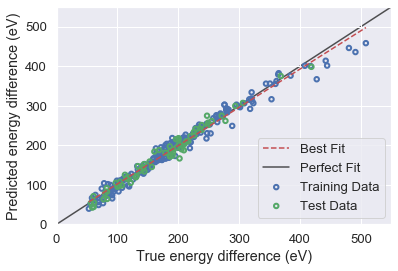

In [14]:
domain = [0, 550]

plot_test_train(y_train, y_test, model_MLP_No_Hidden_layers.predict(X_test), model_MLP_No_Hidden_layers.predict(X_train), range_set=False, range_x=domain, range_y=domain, 
             tag='_Train', mod='MLP', axis_label='energy difference (eV)')
plt.savefig("images/combined-45degree_plot.jpg", dpi=600, bbox_inches='tight')
plt.show()

### ANN Learning curve

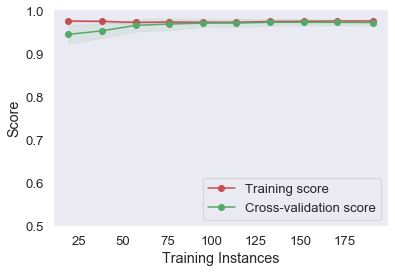

In [15]:
title=""
estimator = model_MLP_No_Hidden_layers
plot_learning_curve(estimator, title, X_train, y_train, \
                    ylim=(0.5, 1.005), cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.savefig(f'images/combined-LearningCurve_MLP.png', dpi = 600, bbox_inches='tight')
plt.show()

### ANN analytic expression

In [16]:
print ("Weights: ")
for i in range(len(model_MLP_No_Hidden_layers.coefs_)):
    number_neurons_in_layer = model_MLP_No_Hidden_layers.coefs_[i].shape[1]
    for j in range(number_neurons_in_layer):
        weights = model_MLP_No_Hidden_layers.coefs_[i][:,j]
        print(i, j, weights, end=", ")
        print()
    print()

print ("Biases: ")    
for i in range(len(model_MLP_No_Hidden_layers.coefs_)):
    print(model_MLP_No_Hidden_layers.intercepts_[i])
    print()

if(len(model_MLP_No_Hidden_layers.coefs_) == 1):
    print("Final equation from neural network:")
    for i in range(len(important_headers)):
        print(str(round(model_MLP_No_Hidden_layers.coefs_[0][:,0][i],4))+"*"+str(important_headers[i]), end=" + ")
    print(round(model_MLP_No_Hidden_layers.intercepts_[0][0],3))

Weights: 
0 0 [   0.42825766  -11.40794819  -38.16226408   -7.42988918   11.33512587
   16.28311003   -1.54885661   34.04543202   14.19005815 -131.98507819
   45.38209926    7.00557821], 

Biases: 
[2.07534112]

Final equation from neural network:
0.4283*N_total + -11.4079*R_avg + -38.1623*BA_std + -7.4299*CN_kurt + 11.3351*ABL_std + 16.2831*BA_avg + -1.5489*R_max + 34.0454*ABL_max + 14.1901*CN_std + -131.9851*BL_min + 45.3821*BL_std + 7.0056*ABL_skew + 2.075


# Linear Regression Model

Since the neural network performed optimally with the identity activation function and no hidden layers. This is equivalent to a linear regression so instead of using the neural network described above, a linear regression will now be tested on the dataset

In [17]:
start=time.time()
linear_reg_model = LinearRegression().fit(X_train, y_train)
stop=time.time()

training_score = linear_reg_model.score(X_train, y_train)
testing_score = linear_reg_model.score(X_test, y_test)

print('Training score:', np.round(training_score, 6))
print('Testing score:', np.round(testing_score, 6))
print(f"Training time: {stop - start}s")


Training score: 0.985919
Testing score: 0.984176
Training time: 0.003990650177001953s


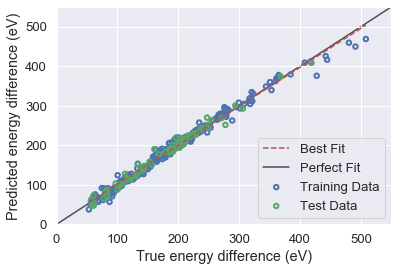

In [18]:
domain = [0, 550]

plot_test_train(y_train, y_test, linear_reg_model.predict(X_test), linear_reg_model.predict(X_train), range_set=False, range_x=domain, range_y=domain, 
             tag='_Train', mod='MLP', axis_label='energy difference (eV)')
plt.savefig("images/combined-45degree_plot_linear_regression.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [19]:
print("Final equation from linear regression:")
for i in range(len(important_headers)):
    print(str(round(linear_reg_model.coef_[0][i],4))+"*"+str(important_headers[i]), end=" + ")
print(round(linear_reg_model.intercept_[0],3))

Final equation from linear regression:
0.4627*N_total + -17.981*R_avg + -23.9623*BA_std + -17.7445*CN_kurt + 82.1278*ABL_std + 19.9278*BA_avg + -0.1382*R_max + -129.5544*ABL_max + -12.7061*CN_std + -91.5954*BL_min + 843.4845*BL_std + -1.923*ABL_skew + -491.859
